In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('train_transaction.csv')

In [4]:
df_id = pd.read_csv('train_identity.csv')

In [5]:
df = pd.merge(df, df_id, how='left', on='TransactionID')

In [6]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
sketchy_devices = list(df.groupby('DeviceInfo').isFraud.agg([np.mean, len]).query('len>10').query('mean>.5').index)

In [8]:
sketchy_browser = list(df.groupby('id_31').isFraud.agg([np.mean, len]).query('len>10').query('mean>.15').index)

In [9]:
#Dealing with NA
df.fillna(0, inplace=True)
#Variable Creation
df['has_r'] = (pd.notna(df['R_emaildomain'])).astype(int)
df['different_r'] = (df['has_r']) * (df.P_emaildomain == df.R_emaildomain).astype(int)
df['is_discover'] = (df.card4=='discover').astype(int)
df['is_credit'] = (df.card6=='credit').astype(int)
df['is_sketchy_addr2'] = (df.addr2.isin([0,60,96]))
df['is_na_M1'] = (df['M1']==0).astype(int)
df['is_na_M2'] = (df['M2']==0).astype(int)
df['is_na_M3'] = (df['M3']==0).astype(int)
df['is_na_M5'] = (df['M5']==0).astype(int)
df['is_na_M6'] = (df['M6']==0).astype(int)
df['is_na_M7'] = (df['M7']==0).astype(int)
df['is_na_M8'] = (df['M8']==0).astype(int)
df['is_na_M9'] = (df['M9']==0).astype(int)
df['is_big_NA'] = df['is_na_M1']*df['is_na_M2']*df['is_na_M3']*df['is_na_M5']*df['is_na_M6']*df['is_na_M7']*df['is_na_M8']*df['is_na_M9']
df['is_C'] = (df.ProductCD=='C').astype(int)
df['is_S'] = (df.ProductCD=='S').astype(int)
df['is_H'] = (df.ProductCD=='H').astype(int)
df['is_mobile'] = (df.DeviceType=='mobile').astype(int)
df['is_sketchy_device'] = (df.DeviceInfo.isin(sketchy_devices)).astype(int)
df['is_sketchy_browser'] = (df.id_31.isin(sketchy_browser)).astype(int)
df['is_protonmail'] = (df.P_emaildomain=='protonmail.com').astype(int)
df['is_elsewise_sketchy_email'] = (df.P_emaildomain.isin(['mail.com', 'outlook.es', 'aim.com', 'outlook.com']))
df['is_match'] = (df.id_34=='match_status:1').astype(int)
df['is_M4M2'] = (df['M4']=='M2').astype(int)
df['is_M3'] = (df['M3']=='T').astype(int)
df['is_M2'] = (df['M2']=='T').astype(int)
df['is_M9'] = (df['M9']=='T').astype(int)
df['is_no_info'] = (df.DeviceType==0).astype(int)


In [10]:
#Column Selection
def colSelect(cols):
    output = []
    for col in cols:
        if col in ['isFraud', 'DeviceType', 'DeviceInfo']:
            output.append(False)
        elif col[0]=='C':
            output.append(True)
        elif col[0]=='V':
            output.append(True)
        elif col[0]=='D':
            output.append(True)
        elif col in ['has_r', 'different_r', 'dist1', 'dist2', 'card1', 'card2', 'card3', 'card5', 'TransactionAmt']:
            output.append(True)
        elif col[0:2]=='is':
            output.append(True)
        else:
            output.append(False)
    return(output)

In [11]:
cols = df.columns[colSelect(df.columns)]

In [12]:
from xgboost import XGBClassifier

In [37]:
xgb1 = XGBClassifier(n_estimators=300, max_depth=7, n_jobs=4, subsample=.8, colsample_bytree=.8)

In [38]:
xgb1.fit(df[cols], df['isFraud'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.8, verbosity=1)

In [53]:
colname=[]
imp=[]
for a,b in zip(cols, xgb1.feature_importances_):
    colname.append(a)
    colname.append(b)

array([1.6649863e-03, 1.5977294e-03, 1.7033510e-03, 3.9484408e-03,
       1.3895457e-03, 1.6274889e-03, 1.0199494e-03, 4.6483534e-03,
       2.0000793e-03, 1.8907618e-03, 3.9064768e-03, 1.6057119e-03,
       2.2474749e-03, 5.7711075e-03, 4.6683778e-03, 2.0326565e-03,
       1.9337349e-03, 4.2130174e-03, 3.6387027e-03, 3.1851910e-03,
       8.3972365e-03, 1.6059267e-03, 3.4430129e-03, 2.0216843e-03,
       1.6840443e-03, 6.8784668e-04, 1.1992846e-03, 7.1213808e-04,
       1.3447029e-03, 7.3197944e-04, 1.4774438e-03, 1.3465590e-03,
       1.1877771e-03, 1.4769267e-03, 7.7617262e-04, 1.8010284e-03,
       4.1075598e-04, 1.0387358e-03, 8.3598605e-04, 8.9297758e-04,
       1.0639889e-03, 1.2993731e-03, 1.0663976e-03, 1.4750245e-03,
       1.2396410e-03, 8.4791647e-04, 8.4326026e-04, 2.7034853e-03,
       2.1047594e-03, 7.5890892e-04, 4.0493500e-03, 8.8786118e-04,
       1.4448565e-03, 1.1075083e-03, 1.4036953e-03, 1.8481632e-03,
       2.6736497e-03, 4.5058457e-03, 7.8229769e-04, 1.4259341e

In [39]:
df['preds'] = xgb1.predict_proba(df[cols])[:, 1]

In [40]:
from sklearn.metrics import auc, roc_curve

In [41]:
fpr, tpr, thresholds= roc_curve(df['isFraud'], df['preds'])

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

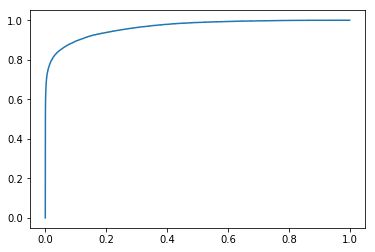

In [43]:
plt.plot(fpr, tpr)

In [44]:
auc(fpr, tpr)

0.9643981327850172

In [45]:
test = pd.read_csv('test_transaction.csv')

In [46]:
test_id = pd.read_csv('test_identity.csv')

In [47]:
test = pd.merge(test, test_id, how='left', on='TransactionID')

In [48]:
#Dealing with NA
test.fillna(0, inplace=True)
#Variable Creation
test['has_r'] = (pd.notna(test['R_emaildomain'])).astype(int)
test['different_r'] = (test['has_r']) * (test.P_emaildomain == test.R_emaildomain).astype(int)
test['is_discover'] = (test.card4=='discover').astype(int)
test['is_credit'] = (test.card6=='credit').astype(int)
test['is_sketchy_addr2'] = (test.addr2.isin([0,60,96]))
test['is_na_M1'] = (test['M1']==0).astype(int)
test['is_na_M2'] = (test['M2']==0).astype(int)
test['is_na_M3'] = (test['M3']==0).astype(int)
test['is_na_M5'] = (test['M5']==0).astype(int)
test['is_na_M6'] = (test['M6']==0).astype(int)
test['is_na_M7'] = (test['M7']==0).astype(int)
test['is_na_M8'] = (test['M8']==0).astype(int)
test['is_na_M9'] = (test['M9']==0).astype(int)
test['is_big_NA'] = test['is_na_M1']*test['is_na_M2']*test['is_na_M3']*test['is_na_M5']*test['is_na_M6']*test['is_na_M7']*test['is_na_M8']*test['is_na_M9']
test['is_C'] = (test.ProductCD=='C').astype(int)
test['is_S'] = (test.ProductCD=='S').astype(int)
test['is_H'] = (test.ProductCD=='H').astype(int)
test['is_mobile'] = (test.DeviceType=='mobile').astype(int)
test['is_sketchy_device'] = (test.DeviceInfo.isin(sketchy_devices)).astype(int)
test['is_sketchy_browser'] = (test.id_31.isin(sketchy_browser)).astype(int)
test['is_protonmail'] = (test.P_emaildomain=='protonmail.com').astype(int)
test['is_elsewise_sketchy_email'] = (test.P_emaildomain.isin(['mail.com', 'outlook.es', 'aim.com', 'outlook.com']))
test['is_match'] = (test.id_34=='match_status:1').astype(int)
test['is_M4M2'] = (test['M4']=='M2').astype(int)
test['is_M3'] = (test['M3']=='T').astype(int)
test['is_M2'] = (test['M2']=='T').astype(int)
test['is_M9'] = (test['M9']=='T').astype(int)
test['is_no_info'] = (test.DeviceType==0).astype(int)


In [49]:
test['preds'] = xgb1.predict_proba(test[cols])[:, 1]

In [50]:
submission_df = pd.DataFrame({'TransactionID':test['TransactionID'], 'isFraud': test['preds']})

In [51]:
submission_df.to_csv('submission_3.csv', index=False)